# OptOut Project: Constructing Independent Variables

## For subsample - childbirth year >= 1980

March 2015

In [180]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [181]:
# helper functions

def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def print_full(x):
    """display full table in this notebook"""
    
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', x.shape[1])
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    
    
def list_duplicates_of(seq, item):
    """
    Given a seq and item, return the indexes of duplicate items in the list (as a list).
    (found online)
    """
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

# Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [182]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [183]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

In [184]:
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

# Get sub-sample with child birth year >= 1980

In [200]:
# read entire sample
iv_df = pd.read_csv('../data/iv_df_for_testing.csv') 
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,3.4,3.0,3,2,20.0,3.9505,11,78,125,1
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,3.0,3.0,3,3,28.0,6.0890,48,9,159,9
2,4,1980,8,1962,8,17,1,0.0,0,0,...,2.2,3.0,3,2,199.0,10.9075,107,16,90,5
3,8,1976,3,1958,7,17,1,0.0,0,0,...,2.4,4.0,3,3,38.0,13.2495,127,11,63,3
4,16,1990,2,1958,10,31,3,27263.0,1,1,...,2.2,2.0,3,3,42.0,13.2585,89,117,0,0


In [201]:
# keep only mothers with first birth after 1980
print iv_df.shape
iv_df = iv_df[iv_df.childbirth_year>=1980]
print iv_df.shape

(3434, 24)
(2514, 24)


# Construct IVs specific to subsample

### Hourly rate and tenure of the last job held one year pre-birth

NLSY79 has two sets of job variables, one under the section "employment history" and one under "employment roster." It seems like they are the same data (https://www.nlsinfo.org/content/cohorts/nlsy79/topical-guide/employment/nlsy79-employer-history-roster), except that employment roster made it easier to link across employers. 

The two methods returned results that are highly correlated. We will use method 1.  

In [187]:
# read datasets
hrrate_df = pd.read_csv("../data/hrrate.csv") # UP TO DATE
jobdates_df = pd.read_csv("../data/jobdates.csv") # week number when job starts/ends - UP TO DATE
cps_id_df = pd.read_csv("../data/cps_id.csv") # UP TO DATE
workhours_df = pd.read_csv("../data/hours_worked.csv") # hours per week worked on job - UP TO DATE
intdate_df = pd.read_csv("../data/int_date.csv") # interview dates - UP TO DATE
prevjobnum_df = pd.read_csv("../data/prev_job_num.csv") 

In [188]:
hrrate_df.head()

,caseid_1979,cpshrp_1979,hrp1_1979,hrp2_1979,hrp3_1979,hrp4_1979,hrp5_1979,cpshrp_1980,hrp1_1980,hrp2_1980,...,hrp1_2012,hrp2_2012,hrp3_2012,hrp4_2012,hrp5_2012,hrp1_2014,hrp2_2014,hrp3_2014,hrp4_2014,hrp5_2014
0,1,328,328,-4,-4,-4,-4,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,385,385,-4,-4,-4,-4,457,457,-4,...,1098,-4,-4,-4,-4,1153,-4,-4,-4,-4
2,3,365,365,-4,275,-4,-4,397,397,367,...,1800,-4,-4,-4,-4,1923,721,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,310,310,375,-4,-4,-4,333,333,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [189]:
jobdates_df.head()

,caseid_1979,start_wk_1979_job01_xrnd,start_wk_1979_job02_xrnd,start_wk_1979_job03_xrnd,start_wk_1979_job04_xrnd,start_wk_1979_job05_xrnd,stop_wk_1979_job01_xrnd,stop_wk_1979_job02_xrnd,stop_wk_1979_job03_xrnd,stop_wk_1979_job04_xrnd,...,start_wk_2014_job01_xrnd,start_wk_2014_job02_xrnd,start_wk_2014_job03_xrnd,start_wk_2014_job04_xrnd,start_wk_2014_job05_xrnd,stop_wk_2014_job01_xrnd,stop_wk_2014_job02_xrnd,stop_wk_2014_job03_xrnd,stop_wk_2014_job04_xrnd,stop_wk_2014_job05_xrnd
0,1,21,0,-4,-4,-4,61,20,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,19,-4,-4,-4,-4,60,-4,-4,-4,...,1823,-4,-4,-4,-4,1929,-4,-4,-4,-4
2,3,37,20,5,-4,-4,57,30,15,-4,...,1838,1892,-4,-4,-4,1948,1918,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,5,23,-4,-4,-4,67,35,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [190]:
cps_id_df.head()

,caseid_1979,job01_1980,job02_1980,job03_1980,job04_1980,job05_1980,job01_1981,job02_1981,job03_1981,job04_1981,...,job06_2014,job07_2014,job08_2014,job09_2014,job10_2014,job11_2014,job12_2014,job13_2014,job14_2014,job15_2014
0,1,-5,-5,-5,-5,-5,1,-4,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,1,-4,-4,-4,-4,1,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,1,0,0,-4,-4,-5,-5,-5,-5,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,4,-5,-5,-5,-5,-5,-4,-4,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,1,0,-4,-4,-4,1,0,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [191]:
workhours_df.head()

,caseid_1979,hour_a_01_1979,hour_a_02_1979,hour_a_03_1979,hour_a_04_1979,hour_a_05_1979,cps_hour_a_1980,hour_a_01_1980,hour_a_02_1980,hour_a_03_1980,...,hour_d_01_2014,hour_d_02_2014,hour_d_03_2014,hour_d_04_2014,hour_d_05_2014,hour_b_01_2014,hour_b_02_2014,hour_b_03_2014,hour_b_04_2014,hour_b_05_2014
0,1,38,15,-4,-4,-4,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,35,-4,-4,-4,-4,35,-4,-4,-4,...,35,-4,-4,-4,-4,0,-4,-4,-4,-4
2,3,35,-3,40,-4,-4,37,-4,40,35,...,40,-4,-4,-4,-4,0,-4,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,12,40,-4,-4,-4,12,-4,40,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [192]:
intdate_df.head()

,caseid_1979,date_m_1979,date_d_1979,date_m_1980,date_d_1980,date_m_1981,date_d_1981,date_m_1982,date_d_1982,date_m_1983,...,date_y_2008,date_d_2010,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014
0,1,3,3,-5,-5,6,25,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,2,28,3,3,2,23,2,6,2,...,2008,10,3,2010,3,12,2012,26,12,2014
2,3,2,8,5,20,-5,-5,3,11,3,...,2008,-5,-5,-5,19,3,2013,8,5,2015
3,4,2,8,-5,-5,3,24,3,3,1,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,4,19,4,3,3,12,3,1,4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [193]:
prevjobnum_df.head()

,caseid_1979,sample_race_78scrn,sample_sex_1979,prev_emp_1980_job01,prev_emp_1980_job02,prev_emp_1980_job03,prev_emp_1980_job04,prev_emp_1980_job05,prev_emp_1981_job01,prev_emp_1981_job02,...,prev_emp_2012_job01,prev_emp_2012_job02,prev_emp_2012_job03,prev_emp_2012_job04,prev_emp_2012_job05,prev_emp_2014_job01,prev_emp_2014_job02,prev_emp_2014_job03,prev_emp_2014_job04,prev_emp_2014_job05
0,1,3,2,-4,-4,-4,-4,-4,1,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,3,2,1,-4,-4,-4,-4,1,-4,...,1,-4,-4,-4,-4,1,-4,-4,-4,-4
2,3,3,2,-4,-4,1,-4,-4,-4,-4,...,-4,1,-4,-4,-4,1,-4,-4,-4,-4
3,4,3,2,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,3,1,1,-4,-4,-4,-4,1,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [194]:
df79 = pd.read_csv('../data/work_history79.csv')
df79.head()

,caseid_1979,employer_startdate_01_m_1979,employer_startdate_01_d_1979,employer_startdate_01_y_1979,employer_startdate_02_m_1979,employer_startdate_02_d_1979,employer_startdate_02_y_1979,employer_startdate_03_m_1979,employer_startdate_03_d_1979,employer_startdate_03_y_1979,...,nonemployed_prior_int_01_1979,nonemployed_prior_int_02_1979,nonemployed_prior_int_03_1979,nonemployed_prior_int_04_1979,nonemployed_prior_int_05_1979,nonemployed_since_int_01_1979,nonemployed_since_int_02_1979,nonemployed_since_int_03_1979,nonemployed_since_int_04_1979,nonemployed_since_int_05_1979
0,1,5,22,78,9,20,75,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
1,2,5,8,78,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
2,3,9,11,78,5,15,78,1,30,78,...,-4,-4,-4,-4,-4,0,0,0,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,2,1,78,6,5,78,-4,-4,-4,...,-4,-4,-4,-4,-4,1,0,-4,-4,-4


In [195]:
#find the range of job numbers: 1-5
import re
job_num = set([])

for col in jobdates_df.columns[1:]:
    job_num.add(re.search(r'job\d{2}', col).group(0)[3:])
    
print job_num

set(['02', '03', '01', '04', '05'])


In [196]:
# see what possible scenarios are out there

count = defaultdict(list)
count_missing = defaultdict(list)
years = range(1979, 1995) + range(1996, 2013, 2) # survey years


merged = iv_df.merge(jobdates_df, on='caseid_1979')



def drop_redundant_jobs(i, jobs):
    """
    Jobs that last across multiple survey years have a separate report in each survey year. 
    Drop the earlier references. Return the latest reference. 
    
    i is respondent id. 
    """
    
    jobs = sorted(jobs, key=itemgetter(1)) # sort by year
    to_drop = []
    for j in range(len(jobs)):
        for k in range(j+1, len(jobs)):
            if is_prev_job(i, jobs[j][1], jobs[j][2], jobs[k][1], jobs[k][2]):
                to_drop.append(j)    
                break # stop searching further because each job is only linked to one previous job

    unique_jobs = [jobs[j] for j in range(len(jobs)) if not (j in to_drop)]  
    return unique_jobs


# count what kind of jobs we can find by one year prebirth
for i, row in merged.iterrows():
    
    # find birth year and month
    dob_m = int(row['childbirth_month'])
    dob_y = int(row['childbirth_year'])
    
    # find weeks in the month that is one year pre-birth
    # DO NOT assume birth took place in the last week of the month
    birth_weeks = range(get_week_num(dob_y-1, dob_m, 'first'), get_week_num(dob_y-1, dob_m, 'last')+1)

    # first, find all jobs that started before one year prebirth
    jobs = []
    
    for year in years:   
        for j in range(1, 6):
            start = int(row['start_wk_%i_job%02d_xrnd'%(year, j)])
            end = int(row['stop_wk_%i_job%02d_xrnd'%(year, j)])

            # job must have valid starting/ending week number and started before one year prebirth
            if start >= 0 and end >= 0 and start <= end:
                
                if start <= birth_weeks[-1]:
                    job_weeks = range(start, end+1)
                    if len(set(job_weeks)&set(birth_weeks)) > 0:
                        jobs.append((1, year, j, start, end)) # overlap with one year pre-birth
                    else:
                        jobs.append((0, year, j, start, end)) # only started before one year pre-birth

            elif start == -4 and end == -4: # valid skip
                pass 
            
            else:
                count_missing[row['caseid_1979']].append((year, j, start, end))
                    

    if len(jobs) == 0: # no job found one year pre-birth
        count['no_job'].append(row['caseid_1979'])
        
    else:
        
        jobs = drop_redundant_jobs(row['caseid_1979'], jobs)
        overlap_jobs = [job for job in jobs if job[0] == 1]
        
        if len(overlap_jobs) == 1:
            count['one_overlap'].append(row['caseid_1979'])
        elif len(overlap_jobs) > 1:
            count['multi_overlap'].append(row['caseid_1979'])
        else:
            count['no_overlap'].append(row['caseid_1979'])
 


for k, v in count.items():
    print k, len(v)

no_job 198
multi_overlap 167
no_overlap 459
one_overlap 1690


In [197]:
# how many respondents have missing job dates?
len(count_missing.keys())

217

In [198]:
# check out the first 10 cases with missing dates
for i in range(len(count_missing)):
    k = count_missing.keys()[i]
    print k, count_missing[k]
    
    if i > 10:
        break

3073.0 [(1990, 2, 602, 600)]
1538.0 [(2010, 2, -2, 1669)]
7689.0 [(2010, 1, -2, 1561)]
3079.0 [(1996, 1, 961, 960)]
2569.0 [(1996, 1, 966, 965)]
5135.0 [(1990, 1, 663, 660), (1990, 3, 603, -3)]
4112.0 [(2006, 2, 1269, -2), (2012, 1, -2, 1822)]
2066.0 [(1988, 2, -3, -3)]
19.0 [(1980, 2, 61, 60)]
6164.0 [(1980, 1, 87, 86)]
9817.0 [(1989, 1, 556, -3)]
4632.0 [(1987, 3, 426, -3)]


## <font color='blue'>Consider each scenario</font>



### Scenario 1: no job is found (198 cases)

R had never worked before (198 cases). Hourly rate 0. Tenure 0. As expected, these respondents have 0 for the variable whether working at one year prebirth and 0 for the variable whehter ever held a job one year prebirth. 

---

<font color='red'>BEFORE THE FOLLOWING ANALYSIS: Drop repeated jobs</font>. If a job lasted multiple years and were reported in multiple survey waves, track the same job and drop earlier references of the same job.


### Scenario 2: no overlap (459 cases)

Use the job that lasted the closest to the prebirth date. We previously chosen the job that started the latest by one year prebirth, but the job that lasted the longest is a better choice because this is the job that was active at the time closest to the point one year prebirth. For example, if a respondent had child in June 1989, her one year prebirth is June 1988. She had one job that started in January 1987 adn ended in January 1988, and another job that started in February 1986 and ended in May 1988. We would want to pick the second job to retrieve hourlyr ate and tenure. 

A small number of respondents have multiple jobs ending in the same week. See the rules below for determining primary job. 


### Scenario 3: one overlap (1690 cases)

If the overlaping job was reported in the same year as prebirth year, use it to retrieve job traits. Otherwise, try to trace back to the previous job reported <= prebirth year or closest to prebirth year, and use it to retrieve job traits. 


### Scenario 4: multiple overlaps (167 cases)

See the rules below for determining primary job. 

---

Find the primary job among competing jobs that overlap with the birth month or end in the same week before birth. 
1. If more than one, choose the one with more hours
2. If more than one and hours are a tie or missing hours, use the one that had information about it reported in a more recent year
3. If more than one, hours are a tie or missing hours, and info reported in the same year, use the one that began longer ago [on the theory that a long-term job is a more "main" job]
4. If more than one, pick job with smallest job number (only one case)

In [172]:
# helper functions


years = range(1979, 1995) + range(1996, 2013, 2)


def is_prev_job(i, y0, n0, y, n):
    """
    Return whether y0, n0 is previous job of y, n.
    
    i is respondent id.
    """
    
    # does not apply when two jobs reported in the same survey year
    if y0 == y:
        return False
    
    # find the previous job number reported for job n in year y
    prev_job_num = prevjobnum_df[prevjobnum_df.caseid_1979==i].iloc[0]['prev_emp_%i_job%02d'%(y, n)]
    
    # if found a valid prev job number
    if prev_job_num >= 1:
        
        ###### find which is the previous year ######
        # there might be missing years, and we will need to skip a few years
        intdate_row = intdate_df[intdate_df.caseid_1979==i].iloc[0]
        
        # pick valid years by checking whether there is valid interview date
        valid_years = [x for x in years if x < y and intdate_row['date_m_%i'%x] > 0]
        
        # the last valid year is the previous year that the previous job was reported 
        prev_year = valid_years[-1]
        
        if prev_year == y0:
            return prev_job_num==n0
        
        if prev_year > y0 and prev_job_num <= 5: # keep searching if the previous job is still after y0
            return is_prev_job(i, y0, n0, prev_year, prev_job_num)
        
    return False


def get_cps_id(i, job_year, job_num):
    row = cps_id_df[cps_id_df.caseid_1979==i].iloc[0]
    
    try:
        return row['job%02d_%i'%(job_num, job_year)]
            
    except KeyError:
        return None

    return None


def get_job_hours(i, job_year, job_num):
    """
    Given respondent id, job year, and job number, 
    find the hours week worked per week on the given job. 
    
    There are several variants of job hours variables. 
    
    If job year is between [1980, 1993], use cps job hours variables. 
    
    If job year is before (<=) 1987, use hour_a variables. 
    
    After 1987, if hour_c variable == 1 (i.e. hour_a includes hours worked at home), use hour_a;
    otherwise, use hour_d variable. 
    
    However, 1998 do not have hour_c variables, so modify the above logic:
    After 1987, user hour_a variable. if hour_d variable is valid positive hours, update to hour_d. 
    
    """
    
    row = workhours_df[workhours_df.caseid_1979==i].iloc[0]
    
    if job_year == 1979: # look for hour_a variables
        return row['hour_a_%02d_%i'%(job_num, job_year)]
    
    elif job_year >= 1980 and job_year <= 1987: # look for cps and hour_a variables
        
        if get_cps_id(i, job_year, job_num) == 1:
            return row['cps_hour_a_%i'%job_year]
        else:
            return row['hour_a_%02d_%i'%(job_num, job_year)]
        
    elif job_year >= 1988 and job_year <= 1993: # look for cps, hour_a, hour_c, and hour_d variables
        
        if get_cps_id(i, job_year, job_num) == 1:
            if row['cps_hour_d_%i'%job_year] >= 0:
                return row['cps_hour_d_%i'%job_year]
            return row['cps_hour_a_%i'%job_year]

        else:
            if row['hour_d_%02d_%i'%(job_num, job_year)] >= 0:
                return row['hour_d_%02d_%i'%(job_num, job_year)]
            return row['hour_a_%02d_%i'%(job_num, job_year)]
            
    elif job_year >= 1994:
        if row['hour_d_%02d_%i'%(job_num, job_year)] >= 0:
            return row['hour_d_%02d_%i'%(job_num, job_year)]
        return row['hour_a_%02d_%i'%(job_num, job_year)]
        
    return None 


def find_primary_job_by_hours(i, jobs):
    """
    Use weekly hours worked to identify the primary job. 
    The most worked job is the primary job. 
    
    If any job has missing hours, return None. 
    If multiple jobs have same max hours, return None. 
    """

    hours = [get_job_hours(i, job[1], job[2]) for job in jobs]
    if sum([h<0 for h in hours]) > 0:
        # print 'invalid hours:', i, jobs, hours
        return None
        
    most_hour = max(hours)
    if hours.count(most_hour) == 1:
        return jobs[hours.index(most_hour)]
    # print 'a tie in hours:', i, jobs, hours
    return None


def get_ref_in_given_year(i, y, n, prebirth_y):
    """
    Given respondent id i, job year y, and job number n, 
    trace the job back to prebirth year and return the job number. 
    
    If missing data in prebirth year, return the job in the latest year before prebirth year.
    """
    
    if y == 1979: # can't go back further than the first wave
        return (y, n)
    
    prev_job_num = prevjobnum_df[prevjobnum_df.caseid_1979==i].iloc[0]['prev_emp_%i_job%02d'%(y, n)]
    
    # if found a valid prev job number
    if prev_job_num >= 1:
        
        # find which is the previous year. due to noninterview, we might have to skip a few years
        intdate_row = intdate_df[intdate_df.caseid_1979==i].iloc[0]
        valid_years = [x for x in years if x < y and intdate_row['date_m_%i'%x] > 0]
        prev_year = valid_years[-1]
        
        if prev_year <= prebirth_y:
            return (prev_year, prev_job_num)
        
        else:
            return get_ref_in_given_year(i, prev_year, prev_job_num, prebirth_y)
        
    else:
        return (y, n)
    

def get_rate(i, job_year, job_num):
    """
    Return hourly rate of the given job. 
    
    If cps job, use cps job hourly rate. 
    
    If missing, return None.
    """
    
    row = hrrate_df[hrrate_df.caseid_1979==i].iloc[0]
    
    rate = None
    
    if job_year >= 1980 and job_year <= 1994:
        if get_cps_id(i, job_year, job_num) == 1:
            rate = row['cpshrp_%i'%job_year]
        else:
            rate = row["hrp%i_%i"%(job_num, job_year)]
            
    else:
        rate = row["hrp%i_%i"%(job_num, job_year)]
        
    if rate < 0:
        rate = None
    return rate


def get_first_ref(i, y, n):
    """
    Given respondent id i, job year y, and job number n, 
    find the first reference the job was reported. 
    """
    
    if y == 1979: # already reached the first survey wave
        return (y, n)
    
    prev_job_num = prevjobnum_df[prevjobnum_df.caseid_1979==i].iloc[0]['prev_emp_%i_job%02d'%(y, n)]
    
    if prev_job_num > 5: # unable to trace back, stop here
        return (y, n)

    elif prev_job_num >= 1: # found a valid prev job number
        
        # find which is the previous year. due to noninterview, we might have to skip a few years
        intdate_row = intdate_df[intdate_df.caseid_1979==i].iloc[0]
        valid_years = [x for x in years if x < y and intdate_row['date_m_%i'%x] > 0]
        prev_year = valid_years[-1]
        
        return get_first_ref(i, prev_year, prev_job_num)
        
    else:
        return (y, n)


def count_weeks(d1, d2):
    """
    Count the number of weeks between the two dates. d1 is earlier than d2
    """
    
    monday1 = d1 - timedelta(days=d1.weekday())
    monday2 = d2 - timedelta(days=d2.weekday())
    return (monday2 - monday1).days/7 + 1    
    
    
def get_tenure(row, y, n, end, prebirth_weeks):
    """
    If job ended during prebirth weeks, use job ending week - job starting week + 1 as tenure. 
    If job ended after prebirth week, use last prebirith week - job starting week + 1 as tenure. 
    
    Two possible ways of under-counting:
    - If a job started in week 0. The weeks prior to 1/1/1978 are unknown
    - When tracing back to previous job, the job was not reported in first five jobs
    """
    
    # first reference when chosen job was reported
    y0, n0 = get_first_ref(row['caseid_1979'], y, n)
    start = int(row['start_wk_%i_job%02d_xrnd'%(y0, n0)])
    
    if start >= 0: # valid value
        
        pre1978_tenure = 0
        if start == 0:
            row = df79[df79.caseid_1979==58].iloc[0]
            
            start_y = row['employer_startdate_%02d_y_1979'%n0]
            start_m = row['employer_startdate_%02d_m_1979'%n0]
            start_d = row['employer_startdate_%02d_d_1979'%n0]

            stop_y = row['employer_stopdate_%02d_y_1979'%n0]
            stop_m = row['employer_stopdate_%02d_m_1979'%n0]
            stop_d = row['employer_stopdate_%02d_d_1979'%n0]
            
            if start_y < 1900 and start_y > 0:
                start_y += 1900
            if stop_y < 1900 and stop_y > 0:
                stop_y += 1900

            # fix missing days
            if start_m > 0 and start_d < 0 and start_d != -4: # assume job started on the 15th
                start_d = 15
                
            if stop_m > 0 and stop_d < 0 and stop_d != -4: # assume job stopped on the 15th
                stop_d = 15            

            if stop_y == -4 and stop_m == -4 and stop_d == -4: # job still current at 1979 interview
                stop_y = 1977
                stop_m = 12
                stop_d = 31
                
            if start_y > 0 and start_m > 0 and start_d > 0 and stop_y > 0 and stop_m > 0 and stop_d > 0:
                pre1978_tenure = count_weeks(datetime(int(start_y), int(start_m), int(start_d)), 
                                             datetime(int(stop_y), int(stop_m), int(stop_d)))
            else:
                print row['caseid_1979'], start_y, start_m, start_d, stop_y, stop_m, stop_d
                return None
                
            

        # if job ended before prebirth month
        if end <= prebirth_weeks[-1]:
            return end - start + 1 + pre1978_tenure
        else:
            return prebirth_weeks[-1] - start + 1 + pre1978_tenure

    return None

In [175]:
counts = defaultdict(int) # count cases


def get_job_traits(row):
    """
    Given a row of respondent data, return hourly rate, 
    rate year (in which hourly rate was reported), and tenure. 
    
    Consider 4 scenarios.
    """
        
    # find birth year and month
    prebirth_y = int(row['childbirth_year']) - 1
    prebirth_m = int(row['childbirth_month'])
    
    
    # find weeks in the month that is one year pre-birth
    # DO NOT assume birth took place in the last week of the month
    prebirth_weeks = range(get_week_num(prebirth_y, prebirth_m, 'first'), 
                           get_week_num(prebirth_y, prebirth_m, 'last')+1)

    # first, find all jobs that started before one year prebirth
    jobs = []
    
    for year in years:   
        for j in range(1, 6):
            start = int(row['start_wk_%i_job%02d_xrnd'%(year, j)])
            end = int(row['stop_wk_%i_job%02d_xrnd'%(year, j)])

            # job must have valid starting/ending week number and started before one year prebirth
            if start >= 0 and end >= 0 and start <= end and start <= prebirth_weeks[-1]:
                job_weeks = range(start, end+1)
                if len(set(job_weeks)&set(prebirth_weeks)) > 0:
                    jobs.append((1, year, j, start, end)) # overlap with one year pre-birth
                else:
                    jobs.append((0, year, j, start, end)) # only started before one year pre-birth
                    

    ###### scenario 1: no job reported one year prebirth ######
    if len(jobs) == 0:
        counts['no job'] += 1
        return (0, None, None, None, 0) # hourly rate, report year, start_wk, end_wk, tenure
    

    
    # drop redundance job. keep the latest references of the same jobs - should be closest to one-year-prebirth month
    jobs = drop_redundant_jobs(row['caseid_1979'], jobs)
    overlap_jobs = [job for job in jobs if job[0] == 1]
    
    chosen_job = None # the job to retrieve hourly rate and tenure
    
    
    ################## TASK: FIND chosen_job ##################
    
    ###### scenario 2: there are jobs, not no overlap with prebirth weeks ######
    
    if len(overlap_jobs) == 0:
        counts['no overlap'] += 1
        
        # choose the job that ended closest to prebirth time
        jobs = sorted(jobs, key=itemgetter(4), reverse=True) # sort by ending week 

        # get all jobs with the same max ending week 
        max_wk = jobs[0][4]
        max_end_jobs = [job for job in jobs if job[4] == max_wk] # job(s) with largest ending week

        if len(max_end_jobs) == 1:
            chosen_job = max_end_jobs[0] 
            
        else:
            # decide between multiple job ended closest to prebirth
            # see rules above
            chosen_job = find_primary_job_by_hours(row['caseid_1979'], max_end_jobs)

            if chosen_job: # found by max weekly hour approach
                counts['no overlap, sort hours'] += 1
            else:
                max_end_jobs = sorted(max_end_jobs, key=itemgetter(1)) # sort by reporting year
                min_report_yr = max_end_jobs[0][1] # min report yr means more recent
                min_report_yr_jobs = [job for job in max_end_jobs if job[1] == min_report_yr]
                
                if len(min_report_yr_jobs) == 1:
                    counts['no overlap, sort job reporting year'] += 1
                    chosen_job = min_report_yr_jobs[0]
                    
                else:
                    start_wks = []
                    for job in min_report_yr_jobs:
                        y0, n0 = get_first_ref(row['caseid_1979'], job[1], job[2])
                        start_wks.append(int(row['start_wk_%i_job%02d_xrnd'%(y0, n0)]))

                    if start_wks.count(min(start_wks)) == 1:
                        chosen_job = min_report_yr_jobs[start_wks.index(min(start_wks))]

                    else:
                        print 'still not solved - no overlap', row['caseid_1979'], prebirth_weeks, min_report_yr_jobs, start_wks 


            
                
    ###### scenario 3: there is one overlap job ######           
    elif len(overlap_jobs) == 1:
        counts['one overlap'] += 1
        chosen_job = overlap_jobs[0]
        
     
    ###### scenario 4: multiple overlapping jobs ######
    elif len(overlap_jobs) > 1:
        counts['multi overlaps'] += 1
                
        chosen_job = find_primary_job_by_hours(row['caseid_1979'], overlap_jobs)

        if chosen_job: # found by max weekly hour approach
            counts['multi overlaps, sort hours'] += 1
        else:
            overlap_jobs = sorted(overlap_jobs, key=itemgetter(1)) # sort by reporting year
            min_report_yr = overlap_jobs[0][1] # min report yr means more recent
            min_report_yr_jobs = [job for job in overlap_jobs if job[1] == min_report_yr]

            if len(min_report_yr_jobs) == 1:
                counts['multi overlap, sort job reporting year'] += 1
                chosen_job = min_report_yr_jobs[0]

            else:
                start_wks = []
                
                for job in min_report_yr_jobs:
                    y0, n0 = get_first_ref(row['caseid_1979'], job[1], job[2])
                    start_wks.append(int(row['start_wk_%i_job%02d_xrnd'%(y0, n0)]))
                    
                if start_wks.count(min(start_wks)) == 1:
                    chosen_job = min_report_yr_jobs[start_wks.index(min(start_wks))]
                    
                else:
                    # one case still not solved: [667, 668, 669, 670] [(1, 1991, 1, 657, 706), (1, 1991, 2, 657, 689)] [585, 585]
                    # so pick the job with smaller job number
                    #print 'still not solved - multi overlap', row['caseid_1979'], prebirth_weeks, min_report_yr_jobs, start_wks # are they from the same years?
                    min_report_yr_jobs = sorted(min_report_yr_jobs, key=itemgetter(2))
                    chosen_job = min_report_yr_jobs[0]
                    
       
    if chosen_job:
            
        ### retrieve job traits of the chosen job ###
        # chosen job was reported in or before prebirth year
        if chosen_job[1] <= prebirth_y: 
            rate = get_rate(row['caseid_1979'], chosen_job[1], chosen_job[2])
            report_year = chosen_job[1]
            start_week = chosen_job[3]
            end_week = chosen_job[4]
            tenure = get_tenure(row, chosen_job[1], chosen_job[2], chosen_job[4], prebirth_weeks)
            return (rate, report_year, start_week, end_week, tenure)

        # otherwise, try to trace back as far as possible and find the chosen job reported in prebirth year 
        
        # even if chosen job can't be traced back to before prebirth year, 
        # get the earliest possible/closest to prebirth year
        else:
            y, n = get_ref_in_given_year(row['caseid_1979'], chosen_job[1], chosen_job[2], prebirth_y)
            rate = get_rate(row['caseid_1979'], y, n)
            report_year = y
            start_week = int(row['start_wk_%i_job%02d_xrnd'%(y, n)])
            end_week = int(row['stop_wk_%i_job%02d_xrnd'%(y, n)])
            tenure = get_tenure(row, chosen_job[1], chosen_job[2], chosen_job[4], prebirth_weeks)
            return (rate, report_year, start_week, end_week, tenure)

    else:
        return (0, None, None, None, 0) 


    
                      
merged = iv_df.merge(jobdates_df, on='caseid_1979')
res = merged.apply(get_job_traits, axis=1)

In [176]:
rate = map(itemgetter(0), res)
report_y = map(itemgetter(1), res)
start_wk = map(itemgetter(2), res)
end_wk = map(itemgetter(3), res)
tenure = map(itemgetter(4), res)

In [177]:
print sum([r==None for r in rate])
print sum([x==None for x in report_y])
print sum([x==None for x in start_wk])
print sum([x==None for x in tenure])

204
198
198
4


In [178]:
counts

defaultdict(int,
            {'multi overlap, sort job reporting year': 5,
             'multi overlaps': 167,
             'multi overlaps, sort hours': 138,
             'no job': 198,
             'no overlap': 459,
             'no overlap, sort hours': 3,
             'one overlap': 1690})

In [202]:
# merge with iv_df
merged['rate'] = map(itemgetter(0), res)
merged['report_y'] = map(itemgetter(1), res)
merged['start_wk'] = map(itemgetter(2), res)
merged['end_wk'] = map(itemgetter(3), res)
merged['tenure'] = map(itemgetter(4), res)
iv_df = iv_df.merge(merged[['caseid_1979', 'rate', 'report_y', 'start_wk', 'end_wk', 'tenure']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,3.9505,11,78,125,1,1263.0,1992.0,706.0,775.0,726.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,6.0890,48,9,159,9,397.0,1980.0,118.0,124.0,14.0
2,4,1980,8,1962,8,17,1,0.0,0,0,...,10.9075,107,16,90,5,0.0,NaN,NaN,NaN,0.0
3,16,1990,2,1958,10,31,3,27263.0,1,1,...,13.2585,89,117,0,0,1586.0,1989.0,560.0,609.0,130.0
4,19,1987,11,1957,12,29,2,11141.0,1,1,...,0.0000,0,0,216,1,565.0,1986.0,411.0,426.0,56.0


In [203]:
# what values of working and had_job do people who had no prebirth job have?
# had_job has some value 1 because it is meausred as the month right before birth, 
# rather than one year prior to birth

tmp = iv_df[(iv_df.report_y.isnull())]
pd.crosstab(tmp.working, tmp.had_job)

had_job,0,1
working,,
0,146,52


In [204]:
# number of missing hourly rates
sum(iv_df.rate.isnull())

204

In [44]:
# number of missing tenure
sum(iv_df.tenure.isnull())

2

In [205]:
# the gap (number of years) between the year hourly rate was reported and prebirth year
# positive number means the year hourly rate was reported is after prebirth year

# the 19-year gap happened to respondent 5767. she had one overlapping job (2002, 2, 146, 1287) 
# that wasn't reported before

gap = iv_df.report_y - (iv_df.childbirth_year - 1)
gap.value_counts()

 0.0     1746
 1.0      391
-1.0       92
-2.0       30
-3.0       12
 2.0       11
-4.0       11
 4.0        5
 3.0        5
-5.0        4
-6.0        2
-12.0       1
 19.0       1
 12.0       1
 8.0        1
 6.0        1
 5.0        1
 10.0       1
dtype: int64

In [206]:
iv_df[((iv_df.start_wk==0) | (iv_df.end_wk==0))]

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure
89,333,1980,10,1957,2,23,2,9080.0,1,1,...,16.8720,144,61,7,1,562.0,1979.0,0.0,69.0,326.0
91,338,1980,7,1959,12,20,2,3140.0,1,1,...,14.8050,171,5,40,1,333.0,1979.0,0.0,65.0,313.0
183,704,1980,8,1958,6,22,3,8280.0,1,1,...,18.5400,214,0,0,0,726.0,1979.0,0.0,67.0,317.0
268,1056,1980,1,1959,7,20,2,7897.0,1,1,...,14.0625,127,41,48,7,320.0,1979.0,0.0,60.0,287.0
277,1090,1980,11,1964,3,16,1,NaN,0,1,...,7.6715,70,17,119,8,100.0,1979.0,0.0,63.0,311.0
342,1352,1980,10,1958,10,21,2,7840.0,1,1,...,3.3995,35,12,169,4,319.0,1979.0,0.0,60.0,326.0
486,1868,1980,10,1957,8,23,3,6405.0,1,1,...,12.3165,123,8,81,2,357.0,1979.0,0.0,66.0,326.0
544,2104,1980,2,1957,1,23,2,9800.0,1,1,...,12.1515,87,66,48,5,375.0,1979.0,0.0,63.0,291.0
606,2368,1980,4,1957,6,22,2,11028.0,1,1,...,18.1215,212,0,0,0,NaN,1979.0,0.0,64.0,300.0
764,2970,1980,12,1957,10,23,2,NaN,1,1,...,0.0000,0,9,206,1,NaN,1979.0,0.0,80.0,335.0


In [207]:
# it may be problematic when the gap is large
# when we convert hourly rate to 2016 dollar, the conversion rate varies by year

# I think we should use the year when the job ended as the year for conversion rate because 
# hourly rate is more likely to be recalled at the time the job ended

def convert_to_year_helper(x):
    """
    Convert week number to year
    """
    if pd.isnull(x):
        return None
    elif x == 0: # does not apply to end_year
        return 1977
    else:
        return get_year_month(x)[0]
    
def convert_to_year(row, name):
    """
    Convert week number to year
    """
    if pd.isnull(row['rate']):
        return None
    return convert_to_year_helper(row[name])

#iv_df['start_year'] = iv_df.apply(lambda row: convert_to_year(row, 'start_wk'), axis=1)
iv_df['end_year'] = iv_df.apply(lambda row: convert_to_year(row, 'end_wk'), axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,end_year
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,11,78,125,1,1263.0,1992.0,706.0,775.0,726.0,1992.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,48,9,159,9,397.0,1980.0,118.0,124.0,14.0,1980.0
2,4,1980,8,1962,8,17,1,0.0,0,0,...,107,16,90,5,0.0,NaN,NaN,NaN,0.0,NaN
3,16,1990,2,1958,10,31,3,27263.0,1,1,...,89,117,0,0,1586.0,1989.0,560.0,609.0,130.0,1989.0
4,19,1987,11,1957,12,29,2,11141.0,1,1,...,0,0,216,1,565.0,1986.0,411.0,426.0,56.0,1986.0


In [209]:
# end year is the same or before report year
tmp = iv_df[~iv_df.end_year.isnull()] # remove missing
(tmp.report_y - tmp.end_year).value_counts()

0.0    1756
1.0     343
2.0       5
6.0       2
4.0       2
3.0       2
8.0       1
5.0       1
dtype: int64

In [210]:
# end year compared to prebirth year
tmp = iv_df[~iv_df.end_year.isnull()] # remove missing
(tmp.end_year - (tmp.childbirth_year-1)).value_counts()

 0.0     1624
 1.0      204
-1.0      190
-2.0       47
-3.0       17
-4.0        9
-5.0        5
-6.0        3
 4.0        3
 3.0        3
 2.0        3
-12.0       1
 19.0       1
 12.0       1
 8.0        1
dtype: int64

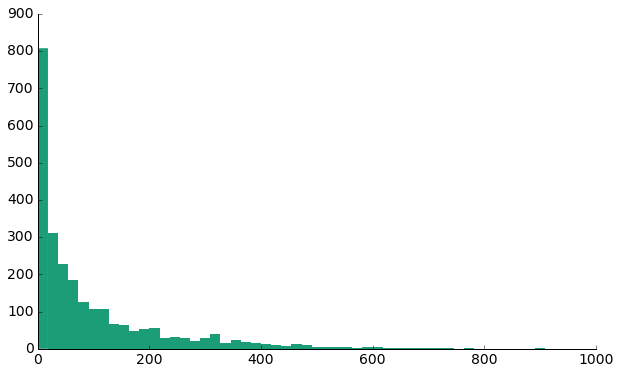

In [211]:
# distribution of tenure
t = iv_df.tenure[~iv_df.tenure.isnull()] # remove missing
plt.hist(t, bins=50)
remove_border()

### Convert Hourly Rate to 2016 Dollars

Use the CPI inflation calculator to convert from January of the various year to January of 2016.

https://www.bls.gov/data/inflation_calculator.htm

In [212]:
iv_df.end_year.unique()

array([ 1992.,  1980.,    nan,  1989.,  1986.,  1985.,  1981.,  1984.,
        1993.,  1982.,  1979.,  1983.,  1991.,  1987.,  1990.,  1988.,
        1994.,  1998.,  1978.,  2002.,  1996.,  1995.])

In [214]:
# conversation rates from January in year to January in another year
# source: http://data.bls.gov/cgi-bin/cpicalc.pl

convert_dict = {
    1978: 3.79,
    1979: 3.43,
    1980: 3.05,
    1981: 2.72,
    1982: 2.51,
    1983: 2.42,
    1984: 2.32,
    1985: 2.25,
    1986: 2.16,
    1987: 2.13,
    1988: 2.05,
    1989: 1.96,
    1990: 1.86,
    1991: 1.76,
    1992: 1.72,
    1993: 1.66,
    1994: 1.62,
    1995: 1.58,
    1996: 1.53,
    1998: 1.47,
    2002: 1.34}


def convert_to_current_dollar(x, yr):
    """
    Given an amount of money x and year yr, 
    return the money in current dollar. 
    """
 
    if np.isnan(x):
        return None
    elif x == 0:
        return 0
    return x*convert_dict[int(yr)]


iv_df['rate'] = iv_df.rate.map(lambda x: x/100.) # convert from cents to dollars
iv_df['rate_adj'] = iv_df.apply(lambda row: convert_to_current_dollar(row['rate'], row['end_year']), axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,num_pt_months,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,end_year,rate_adj
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,78,125,1,12.63,1992.0,706.0,775.0,726.0,1992.0,21.7236
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,9,159,9,3.97,1980.0,118.0,124.0,14.0,1980.0,12.1085
2,4,1980,8,1962,8,17,1,0.0,0,0,...,16,90,5,0.00,NaN,NaN,NaN,0.0,NaN,0.0000
3,16,1990,2,1958,10,31,3,27263.0,1,1,...,117,0,0,15.86,1989.0,560.0,609.0,130.0,1989.0,31.0856
4,19,1987,11,1957,12,29,2,11141.0,1,1,...,0,216,1,5.65,1986.0,411.0,426.0,56.0,1986.0,12.2040


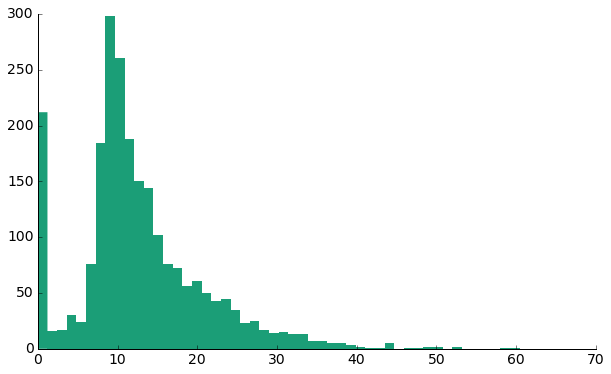

In [215]:
plt.hist(iv_df.rate_adj[((~np.isnan(iv_df.rate_adj)) & (iv_df.rate_adj < 100))], bins=50)
remove_border()

### Spouse pre-birth income

If pre-birth marital status is single or previously married, spouse income is set to 0. If pre-birth marital status is married, look for spouse wage reported in DOB year (because the spouse wage variable is defined to be TOTAL INCOME OF SPOUSE FROM WAGES AND SALARY IN PAST CALENDAR YEAR) and convert wage to 2016 dollar using DOB year -1 as the conversion year. 

In [218]:
spouse_income_df = pd.read_csv('../data/spouse_income.csv')
spouse_income_df.head()

,version_r26_2014,caseid_1979,spouse_income_1979,sample_id_1979,sample_race_78scrn,sample_sex_1979,spouse_income_1980,spouse_income_1981,spouse_income_1982,spouse_income_1983,...,q13_18_sr000002_trunc_2010,q13_18_uab_a_2010,q13_18_uab_b_2010,q13_18_uab_c_2010,q13_18_trunc_2012,q13_18_sr000001_trunc_2012,q13_18_sr000002_trunc_2012,q13_18_uab_a_2012,q13_18_uab_b_2012,q13_18_uab_c_2012
0,-5,1,-4,5,3,2,-5,-4,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,458,2,-4,5,3,2,-4,-4,-4,-4,...,-4,-4,-4,-4,0,-4,-4,-4,-4,-4
2,458,3,-4,5,3,2,-4,-5,10000,9600,...,-5,-5,-5,-5,55000,-4,-4,-4,-4,-4
3,-5,4,-4,5,3,2,-5,14000,10000,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,-5,5,-4,1,3,1,-4,-4,-4,-4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [216]:
iv_df.childbirth_year.unique()

array([1993, 1981, 1980, 1990, 1987, 1988, 1982, 1985, 1994, 1986, 1992,
       1989, 1991, 1984, 1995, 1983])

In [219]:
#version 2 - use spouse salary in dob year because spouse salary was reported for the past calendar year

count = defaultdict(int)
years = range(1979, 1995) + range(1996, 2013, 2)

def get_spouse_income(row):
    """
    Given respondent id i, return (spouse wage, marital status).
    Use spouse wage in DOB year. If missing, use spouse wage in DOB year - 1. 
    """
    
    dob_y = int(row['childbirth_year'])
    
    if row['marstat'] in [0, 2]: #if single or divorced/widowed/separated, return spouse wage of 0
        count[0] += 1
        return 0
    
    elif row['marstat'] == 1:
        
        if dob_y == 1995: # 1995 is not a survey year
            inc = row['spouse_income_1994']
        else:
            inc = row['spouse_income_%s'%dob_y] # income
        
        if inc >= 0:
            count['found in dob_y'] += 1
            return convert_to_current_dollar(inc, dob_y-1)  # income adjusted for inflation  
        
        else:
            prev_inc = row['spouse_income_%s'%(dob_y-1)]
            if prev_inc >= 0:
                count['found in dob_y - 1'] += 1                
                return convert_to_current_dollar(prev_inc, dob_y-2) # income adjusted for inflation  
            else:
                count['missing'] += 1
                return None
    
    # otherwise, if marital status is missing
    else:
        count['missing'] += 1
        return None
        

merged = iv_df.merge(spouse_income_df, on='caseid_1979')
merged["spouse_income_adj"] = merged.apply(get_spouse_income, axis=1)
iv_df = iv_df.merge(merged[['caseid_1979', 'spouse_income_adj']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,num_nonemp_months,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,end_year,rate_adj,spouse_income_adj
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,125,1,12.63,1992.0,706.0,775.0,726.0,1992.0,21.7236,68800.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,159,9,3.97,1980.0,118.0,124.0,14.0,1980.0,12.1085,NaN
2,4,1980,8,1962,8,17,1,0.0,0,0,...,90,5,0.00,NaN,NaN,NaN,0.0,NaN,0.0000,0.0
3,16,1990,2,1958,10,31,3,27263.0,1,1,...,0,0,15.86,1989.0,560.0,609.0,130.0,1989.0,31.0856,64680.0
4,19,1987,11,1957,12,29,2,11141.0,1,1,...,216,1,5.65,1986.0,411.0,426.0,56.0,1986.0,12.2040,NaN


In [220]:
print count

defaultdict(<type 'int'>, {0: 762, 'found in dob_y - 1': 66, 'found in dob_y': 1362, 'missing': 324})


In [221]:
print 'Among the %s married respondents, %s had missing spouse wage'%(iv_df.marstat.values.tolist().count(1), 
                                                                      sum(iv_df.spouse_income_adj.isnull()))

Among the 1735 married respondents, 324 had missing spouse wage


### Spouse's working hours

Use same rule as above. Single and previously married respondents are set to have spouse hours of 0 and spouse hour group 0. If found valid spouse hour in DOB year, use it. Otherwise, try spouse hours in the year before DOB year. 

In [222]:
sphour_df = pd.read_csv('../data/spouse_work_hours.csv')
sphour_df.head()

,caseid_1979,sample_race_1979,sample_sex_1979,spouse_hr_per_wk_1980,spouse_hr_per_wk_1981,spouse_hr_per_wk_1982,spouse_hr_per_wk_1983,spouse_hr_per_wk_1984,spouse_hr_per_wk_1985,spouse_hr_per_wk_1986,...,spouse_hr_per_wk_1994,spouse_hr_per_wk_1996,spouse_hr_per_wk_1998,spouse_hr_per_wk_2000,spouse_hr_per_wk_2002,spouse_hr_per_wk_2004,spouse_hr_per_wk_2006,spouse_hr_per_wk_2008,spouse_hr_per_wk_2010,spouse_hr_per_wk_2012
0,1,3,2,-5,-4,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,3,2,-4,-4,-4,-4,-4,-4,-4,...,37,35,37,40,40,40,-4,-4,-4,-4
2,3,3,2,-4,-5,40,38,40,50,60,...,76,50,50,40,40,-5,40,40,-5,40
3,4,3,2,-5,51,42,90,-4,-4,-2,...,-5,40,40,-5,-5,-5,-5,-5,-5,-5
4,5,3,1,-4,-4,-4,-4,-4,-5,40,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [223]:
count = defaultdict(int)

def get_spouse_hour(row):
    """Given a row of respondent data, return spouse's typical hours worked per week."""
    
    dob_y = int(row['childbirth_year'])
    
    if dob_y == 1995: # not in survey year
        hour = row['spouse_hr_per_wk_1994'] 
    else:
        hour = row['spouse_hr_per_wk_%s'%dob_y] 
    #it is one year pre-birth, but some weird naming convention in NLSY79 makes spouse_hr_per_wk_1980 represents 1979 data
    
    if row["marstat"] == 0: #if single, return spouse hour of 0
        if hour >= 0: # some cases where single or previously married respondents had positive spouse hours!!!
            count[0] += 1
        return 0
    
    elif row["marstat"] == 2: #if divorced/widowed/separated, return spouse hour of 0
        if hour >= 0:
            count[2] += 1
        return 0
    
    elif row["marstat"] == 1: #if married, but spouse hour is missing, impute from surrounding years
        
        if hour >= 0:
            count["hour in dob_y"] += 1
            return hour
        
        if dob_y > 1980: # variable only start in 1980
            hour_prev = sphour_df[sphour_df.caseid_1979==i].iloc[0]['spouse_hr_per_wk_%s'%(dob_y-1)] 
            if hour_prev >= 0:
                count["hour in dob_y - 1"] += 1
                return hour_prev
        
    count["missing"] += 1
    return None


merged = iv_df.merge(sphour_df, on='caseid_1979')
merged['sphour'] = merged.apply(get_spouse_hour, axis=1)

In [225]:
iv_df = iv_df.merge(merged[['caseid_1979', 'sphour']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,num_nonemp_spells,rate,report_y,start_wk,end_wk,tenure,end_year,rate_adj,spouse_income_adj,sphour
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,1,12.63,1992.0,706.0,775.0,726.0,1992.0,21.7236,68800.0,35.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,9,3.97,1980.0,118.0,124.0,14.0,1980.0,12.1085,NaN,NaN
2,4,1980,8,1962,8,17,1,0.0,0,0,...,5,0.00,NaN,NaN,NaN,0.0,NaN,0.0000,0.0,0.0
3,16,1990,2,1958,10,31,3,27263.0,1,1,...,0,15.86,1989.0,560.0,609.0,130.0,1989.0,31.0856,64680.0,60.0
4,19,1987,11,1957,12,29,2,11141.0,1,1,...,1,5.65,1986.0,411.0,426.0,56.0,1986.0,12.2040,NaN,NaN


In [224]:
print count

defaultdict(<type 'int'>, {0: 6, 'hour in dob_y': 1480, 2: 12, 'missing': 272})


In [226]:
#edit hours into categories:
#0-spouse < FT (less than 35 hours per week), 1-full time (35-50 hours per week), 2-overwork (>50 hours per week)

def group_sphours(h):
    
    if h==None:
        return None
    
    elif np.isnan(h):
        return None

    elif h<35: # less than full-time
        return 0
    
    elif h>=35 and h<=50:
        return 1
    
    elif h>50:
        return 2
    
    else:
        print 'unknown hours'
        return None
        

In [227]:
iv_df["sphour_group"] = iv_df.sphour.map(group_sphours)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,rate,report_y,start_wk,end_wk,tenure,end_year,rate_adj,spouse_income_adj,sphour,sphour_group
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,12.63,1992.0,706.0,775.0,726.0,1992.0,21.7236,68800.0,35.0,1.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,3.97,1980.0,118.0,124.0,14.0,1980.0,12.1085,NaN,NaN,NaN
2,4,1980,8,1962,8,17,1,0.0,0,0,...,0.00,NaN,NaN,NaN,0.0,NaN,0.0000,0.0,0.0,0.0
3,16,1990,2,1958,10,31,3,27263.0,1,1,...,15.86,1989.0,560.0,609.0,130.0,1989.0,31.0856,64680.0,60.0,2.0
4,19,1987,11,1957,12,29,2,11141.0,1,1,...,5.65,1986.0,411.0,426.0,56.0,1986.0,12.2040,NaN,NaN,NaN


## Export to csv

In [228]:
#export to csv
iv_df.to_csv('../data/iv_df_subsample.csv', index=False)

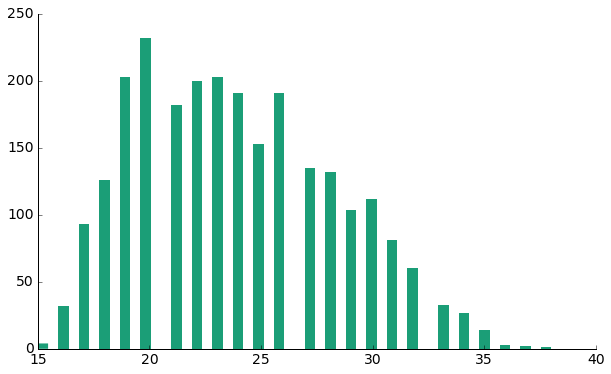

In [229]:
plt.hist(iv_df.age, bins=50)
remove_border()